# Generación de topicos y clasificación de textos según estos

El código utilizado para generar lo tópicos y clasificar los artículos es basado en el artículo [Topic Modelling in Python with spaCy and Gensim](https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf)

In [18]:
# Librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from tqdm import tqdm
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()#
import nltk
import spacy
import os

### Visualizaciones

In [101]:
# Importar documento a procesar
df = pd.read_csv('/Users/'+os.getlogin()+'/OneDrive - Accenture/ACNCustomerAnalysis/data/curated/curated_database.csv', encoding='utf-8-sig', index_col=[0])
columna = 'Contenido'

In [102]:
bigram_measure = nltk.collocations.BigramAssocMeasures()

finder = nltk.collocations.BigramCollocationFinder\
    .from_documents(df[f'{columna} procesado'])
    
# Filtrar aquellos que ocurren al menos 50 veces
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measure.pmi)

In [103]:
trigram_measure = nltk.collocations.TrigramAssocMeasures()

finder = nltk.collocations.TrigramCollocationFinder\
    .from_documents(df[f'{columna} procesado'])
    
# Filtrar aquellos que ocurren al menos 50 veces
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measure.pmi)

In [104]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [105]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [106]:
# Filter for noun-type structures bigrams
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

In [107]:
# Filter for noun-type structures trigrams
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True 

In [108]:
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [109]:
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [110]:
reviews_w_ngrams = df.copy()

In [111]:
reviews_w_ngrams['Contenido'] = reviews_w_ngrams['Contenido'].apply(lambda x: replace_ngram(x))

In [112]:
def procesamiento(columna: str, df: pd.DataFrame):
    """Función para procesar el texto y obtener columnas tokenizada y radicalizada

    Args:
        columna (str): columna a procesar
        df (pd.DataFrame): dataframe en donde se encuentra el texto a procesar

    Returns:
        pd.DataFrame: Data Frame con columna procesada
    """
    # Modelo de spacy que se utilizará
    # spacy.cli.download('es_core_news_md')
    es = spacy.load('es_core_news_md')

    # Etiquetas a remover del texto lematizado
    # Tags I want to remove from the text
    removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT',
               'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']

    # Convertir a objeto spaCy
    aux = df[columna].str.lower().apply(es)

    # Tokenización
    df[f'{columna} procesado'] = aux.apply(
        lambda x: [token for token in x])
    # Normalización (minuscula, tamaño > 3 y solo letras)
    df[f'{columna} procesado'] = df[f'{columna} procesado'].apply(
        lambda x: [token for token in x if len(token) > 3 and token.is_alpha])
    # Remover stopwords (combinación de contexto y spacy).
    # Convertir Token a str
    with open('../NLP_Analitycs/sw_es.txt', 'r', encoding='utf-8') as file:
        stop_words_contexto = {line.split(None, 1)[0] for line in file}
    es.Defaults.stop_words |= stop_words_contexto
    df[f'{columna} procesado'] = df[f'{columna} procesado'].apply(
        lambda x: [token for token in x if not token.is_stop])

    # Segmentación en oraciones
    df[f'{columna} segmentado'] = aux.apply(
        lambda x: ", ".join([segment.orth_ for segment in x.sents]))

    # Extracción de entidades
    df[f'Entidades de {columna}'] = aux.apply(
        lambda x: ", ".join([ent.text for ent in x.ents]))

    # Radicalización (stemming)
    stemmer = nltk.SnowballStemmer('spanish')
    df[f'{columna} radicalizado'] = df[f'{columna} procesado'].apply(
        lambda x: ", ".join([stemmer.stem(token.orth_) for token in x]))
    
    df[f'{columna} procesado'] = df[f'{columna} procesado'].apply(
        lambda x: [token.text for token in x])

In [113]:
procesamiento('Contenido', reviews_w_ngrams)

La puntuación de coherencia de C_v oscila entre 0 (incoherencia total) y 1 (coherencia total). Los valores superiores a 0,5 son bastante buenos, según John McLevey (fuente: Doing Computational Social Science: A Practical Introduction By John McLevey). Por otro lado, C_umass devuelve valores negativos.

In [114]:
df_ecopetrol = reviews_w_ngrams[reviews_w_ngrams['Empresa'] == 'Ecopetrol']

In [115]:
columna = 'Contenido'
df_ecopetrol[f'{columna} lematizado'] = df_ecopetrol[f'{columna} lematizado'].apply(lambda x: x.replace('[', '').replace(']', '').replace('\'', '').split(', '))
dictionary = Dictionary(df_ecopetrol[f'{columna} lematizado'])
# Filtrar los tokens de baja y alta frecuencia. Limitar el vocabulario 
# a un máximo de 100 palabras
dictionary.filter_extremes(no_below=5, no_above=0.5)
# Contar el número de ocurrencias de cada palabra única
corpus = [dictionary.doc2bow(doc) for doc in df_ecopetrol[f'{columna} lematizado']]

C:\Users\andres.ospina\AppData\Local\Temp\ipykernel_16344\1791216388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ecopetrol[f'{columna} lematizado'] = df_ecopetrol[f'{columna} lematizado'].apply(lambda x: x.replace('[', '').replace(']', '').replace('\'', '').split(', '))


In [67]:
# Calcular la coherencia C_umass, C_v y número de topicos
topics = []
score_umass = []
score_v = []
for i in tqdm(range(2,13,1)):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm_umass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   cm_v = CoherenceModel(model=lda_model, texts = df_ecopetrol[f'{columna} lematizado'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score_umass.append(cm_umass.get_coherence())
   score_v.append(cm_v.get_coherence())

100%|██████████| 11/11 [02:15<00:00, 12.27s/it]


In [19]:
# # Método de Pareto (relajado para romper cuando cambie de dirección)
# lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=1, workers = 4, passes=10, random_state=100)
# top_ant = 1
# top_act = None

# cm_umass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass').get_coherence()
# score_ant = cm_umass.get_coherence()
# score_act = None

# for i in tqdm(range(2,13,1)):
#    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
#    top_act = i
#    cm_umass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
#    score_act = cm_umass.get_coherence()
#    m = score_act - score_ant
#    if m >= 0:
#       break
#    top_ant = i
#    score_ant = score_act
   
# top_ant

In [68]:
# Valor mas a la izquierda que sea <= puntaje minimo por 0.9 (entre 2 y 12 topicos)
max_score = max(score_v)
indice = score_v.index(max_score)
for i in range(len(score_v)):
    if score_v[i] >= max_score*(0.9):
        break
n_topics = topics[i]

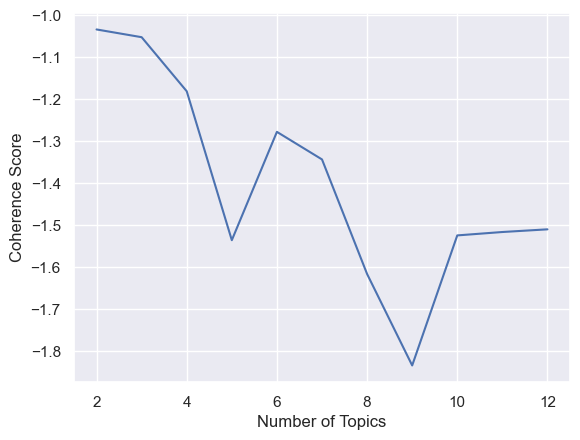

In [69]:
# Visualizar la coherencia C_umass vs número topicos
_=plt.plot(topics, score_umass)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

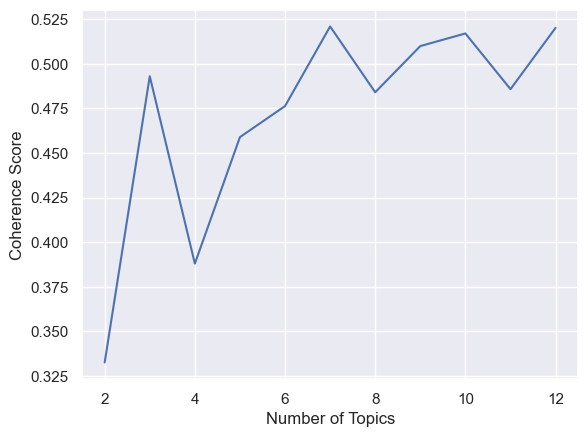

In [70]:
# Visualizar la coherencia C_v vs número topicos
_=plt.plot(topics, score_v)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [116]:
# númeor de iteraciones 50 por defecto
# workers equivale al número de cores del computador
# passes número de veces que pasa por el corpus para entrenarse
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=5, workers=4, passes=10)

In [24]:
topic_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, mds = 'pcoa')

topicos = []
num_terms = 10 # Adjust number of words to represent each topic
lambd = 0.6 # Adjust this accowrdingly based on tuning above
for i in tqdm(range(1, n_topics+1)): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    topicos.append([i, (", ".join(topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values))])

C:\Users\andres.ospina\AppData\Roaming\Python\Python311\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\andres.ospina\AppData\Local\Temp\ipykernel_18452\3130001122.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topicos.append([i, (", ".join(topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values))])
C:\Users\andres.ospina\AppData\Local\Temp\ipykernel_18452\3130001122.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, t

In [117]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(lda_display, 'lda_model.html')
pyLDAvis.display(lda_display)

C:\Users\andres.ospina\AppData\Roaming\Python\Python311\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


### Incluir bigramas y trigramas

[6 Tips for Interpretable Topic Models](https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2)

In [17]:
# Importar documento a procesar
df = pd.read_csv('/Users/'+os.getlogin()+'/OneDrive - Accenture/ACNCustomerAnalysis/data/curated/curated_database.csv', encoding='utf-8-sig', index_col=[0])

In [5]:
# Hasta el momento la única columna procesada ha sido el Contenido
columna = 'Contenido'
df[f'{columna} lematizado'] = df[f'{columna} lematizado'].apply(lambda x: x.replace('[', '').replace(']', '').replace('\'', '').split(', '))
df[f'{columna} procesado'] = df[f'{columna} procesado'].apply(lambda x: x.replace('[', '').replace(']', '').replace('\'', '').split(', '))
dictionary = Dictionary(df[f'{columna} lematizado'])
# Filtrar los tokens de baja y alta frecuencia. Limitar el vocabulario 
# a un máximo de 100 palabras
dictionary.filter_extremes(no_below=5, no_above=0.5)
# Contar el número de ocurrencias de cada palabra única
corpus = [dictionary.doc2bow(doc) for doc in df[f'{columna} lematizado']]

In [6]:
bigram_measure = nltk.collocations.BigramAssocMeasures()

finder = nltk.collocations.BigramCollocationFinder\
    .from_documents(df[f'{columna} procesado'])
    
# Filtrar aquellos que ocurren al menos 50 veces
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measure.pmi)

In [7]:
trigram_measure = nltk.collocations.TrigramAssocMeasures()

finder = nltk.collocations.TrigramCollocationFinder\
    .from_documents(df[f'{columna} procesado'])
    
# Filtrar aquellos que ocurren al menos 50 veces
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measure.pmi)

Para definir si dos palabras se consideran bigramas se utiliza la medida Pointwise Mutual Information (PMI). Mide la probabilidad de que las palabras coincidan más que si fueran independientes. La métrica es sensible a las combinaciones raras de palabras, por lo que se utiliza con un filtro de frecuencia de aparición para garantizar la relevancia de la frase.
$$PMI(w_1, w_2) = log_2\frac{P(w_1, w_2)}{P(w_1)P(w_2)}$$
$$P(w_1) = \frac{Freq(w)}{totalWordCount}$$

In [8]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [9]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

Además, filtramos los bigramas o trigramas con estructuras de sustantivos. Esto ayuda al modelo LDA a agrupar mejor los temas, ya que los sustantivos son mejores indicadores del tema del que se habla. Utilizamos el paquete NLTK para etiquetar las partes de la oración y filtrar estas estructuras.

In [10]:
# Filtro de bigramas de estructuras de tipo sustantivo
def bigram_filter(bigram):
    """Función para identificar si alguna palabra del bigrama los sustantivos

    Args:
        bigram: Token etiquetado con su categoría gramatical

    Returns:
        bool: True si es un sustantivo
    """
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

In [11]:
# Filtro de trigramas de estructuras de tipo sustantivo
def trigram_filter(trigram):
    """Función para identificar si alguna palabra del trigrama es un los sustantivos

    Args:
        bigram: Token etiquetado con su categoría gramatical

    Returns:
        bool: True si es un sustantivo
    """
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True 

In [12]:
# Puede fijar el umbral de PMI a lo que tenga sentido - ojee y seleccione el umbral donde los n-gramas dejan de tener sentido.
# Elija los 500 mejores ngramas, en este caso clasificados por PMI, que tengan estructuras similares a sustantivos.
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [13]:
def replace_ngram(x):
    """FUnción para reemplazar las palabras por los bigramas o trigramas

    Args:
        x (str): String a ser reemplazado

    Returns:
        str: String con la modificación del bigrama o trigrama
    """
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [14]:
reviews_w_ngrams = df.copy()

In [15]:
reviews_w_ngrams['Contenido'] = reviews_w_ngrams['Contenido'].apply(lambda x: replace_ngram(x))

In [16]:
def procesamiento(columna: str, df: pd.DataFrame):
    """Función para procesar el texto y obtener columnas tokenizada y radicalizada

    Args:
        columna (str): columna a procesar
        df (pd.DataFrame): dataframe en donde se encuentra el texto a procesar

    Returns:
        pd.DataFrame: Data Frame con columna procesada
    """
    # Modelo de spacy que se utilizará
    # spacy.cli.download('es_core_news_md')
    es = spacy.load('es_core_news_md')

    # Etiquetas a remover del texto lematizado
    # Tags I want to remove from the text
    removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT',
               'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']

    # Convertir a objeto spaCy
    aux = df[columna].str.lower().apply(es)

    # Tokenización
    df[f'{columna} procesado'] = aux.apply(
        lambda x: [token for token in x])
    # Normalización (minuscula, tamaño > 3 y solo letras)
    df[f'{columna} procesado'] = df[f'{columna} procesado'].apply(
        lambda x: [token for token in x if len(token) > 3 and token.is_alpha])
    # Remover stopwords (combinación de contexto y spacy).
    # Convertir Token a str
    with open('../NLP_Analitycs/sw_es.txt', 'r', encoding='utf-8') as file:
        stop_words_contexto = {line.split(None, 1)[0] for line in file}
    es.Defaults.stop_words |= stop_words_contexto
    df[f'{columna} procesado'] = df[f'{columna} procesado'].apply(
        lambda x: [token for token in x if not token.is_stop])

    # Segmentación en oraciones
    df[f'{columna} segmentado'] = aux.apply(
        lambda x: ", ".join([segment.orth_ for segment in x.sents]))

    # Extracción de entidades
    df[f'Entidades de {columna}'] = aux.apply(
        lambda x: ", ".join([ent.text for ent in x.ents]))

    # Radicalización (stemming)
    stemmer = nltk.SnowballStemmer('spanish')
    df[f'{columna} radicalizado'] = df[f'{columna} procesado'].apply(
        lambda x: ", ".join([stemmer.stem(token.orth_) for token in x]))
    
    df[f'{columna} procesado'] = df[f'{columna} procesado'].apply(
        lambda x: [token.text for token in x])

In [17]:
procesamiento('Contenido', reviews_w_ngrams)

In [18]:
reviews_w_ngrams.index.name = 'ID_Articulo'

### Extraer y asignar temas por clientes

In [19]:
def mejor_puntaje(topicos: list, puntaje_v: list):
    """Función para obtener el mejor puntaje según el criterio definido:
    valor mas a la izquierda que sea >= 0.9 veces el puntaje máximo.
    Solo se consideran entre 2 y 12 topicos para que se mantenga interpretable
    el resultado

    Args:
        topicos (list): lista de enteros entre 2 y 12
        puntaje_v (list): puntaje correspondiente al número de tópicos

    Returns:
        int: entero que indica el número de tópicos a considerar.
    """
    puntaje_max = max(puntaje_v)
    for n in range(len(puntaje_v)):
        if puntaje_v[n] >= puntaje_max*(0.9):
            break
    return topicos[n]

In [20]:
def n_topicos(df: pd.DataFrame, columna: str, corpus: list, diccionario: Dictionary, n_iterations: int = 10, n_workers: int = 4, n_passes: int = 10, n_random_state: int = 100, max_topicos: int = 12, min_topicos: int = 2):
    """Función para obter los puntajes de coherencia para cada uno de los números de tópicos considerados (entre 2 y 12).

    Args:
        df (pd.DataFrame): data frame donde se encuentran los textos a analizar
        columna (str): columna en donde se encuentran los textos
        corpus (list): vector con el id de la palabra y el número de ocurrencias
        diccionario (Dictionary): colección de palabras de valores únicos de los diferentes textos considerados mapeado con su id
        n_iterations (int, optional): número de iteraciones. Por defecto 10.
        n_workers (int, optional): equivale al número de cores del computador. Por defecto 4.
        n_passes (int, optional): número de veces que pasa por el corpus para entrenarse. Por defecto 10.
        n_random_state (int, optional): semilla para un generador de números pseudoaleatorios. Por defecto 100.
        max_topicos (int, optional): número máximo de tópicos a considerar. Por defecto 12.
        min_topicos (int, optional): número mínimo de tópicos a considerar. Por defecto 2.

    Returns:
        int: número de tópicos a considerar en el modelo LDA
    """
    topicos = []
    # puntaje_umass = []
    puntaje_v = []
    for i in tqdm(range(min_topicos,max_topicos + 1,1)):
        lda_model = LdaMulticore(corpus=corpus, id2word=diccionario, iterations=n_iterations, num_topics=i, workers = n_workers, passes=n_passes, random_state=n_random_state)
        # cm_umass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=diccionario, coherence='u_mass')
        cm_v = CoherenceModel(model=lda_model, texts = df[f'{columna} lematizado'], corpus=corpus, dictionary=diccionario, coherence='c_v')
        topicos.append(i)
        # puntaje_umass.append(cm_umass.get_coherence())
        puntaje_v.append(cm_v.get_coherence())
        
    n = mejor_puntaje(topicos, puntaje_v)
    return n

In [21]:
def lda_model(df: pd.DataFrame, columna: str, filtro_inf: int = 1, filtro_sup: float = 0.5, iteraciones: int = 50, workers: int = 4, passes: int = 10, n_palabras: int = None):
    """Creación y ejecución del modelo LDA para la definición de tópicos y asignación de los mismos a los artículos

    Args:
        df (pd.DataFrame): dataframe que contiene los textos ya lematizados
        columna (str): columna de la que se obtendrán los tópicos
        filtro_inf (int, optional): número mínimo de apariciones de una palabra para ser considerada. Por defecto 1.
        filtro_sup (float, optional): proporción máxima de artíulos en los que puede aparecer una palabra. Por defecto 0.2.
        iteraciones (int, optional): número de iteraciones. Por defecto 50. 
        workers (int, optional):  equivale al número de cores del computador. Por defecto 4.
        passes (int, optional): número de veces que pasa por el corpus para entrenarse. Por defecto 10.
        n_palabras (int, optional): número máximo de palabras a considerar en el diccionario. Por defecto None.

    Returns:
        list, pd.DataFrame: lista de los tópicos y sus palabras correspondientes. Clasificación de los artículos por tema
    """
    # El limite inferior se establece en 1 puesto que hay empresas con pocos artículos (2 en el caso de AES chivor)
    # df[f'{columna} lematizado'] = df[f'{columna} lematizado'].apply(lambda x: x.replace('[', '').replace(']', '').replace('\'', '').split(','))
    diccionario = Dictionary(df[f'{columna} lematizado'])
    # diccionario.filter_extremes(no_below=filtro_inf, no_above=filtro_sup, keep_n=n_palabras)
    corpus = [diccionario.doc2bow(doc) for doc in df[f'{columna} lematizado']]
    
    n = n_topicos(df=df, columna=columna, corpus=corpus, diccionario=diccionario)
    
    lda_model = LdaMulticore(corpus=corpus, id2word=diccionario, iterations=iteraciones, num_topics=n, workers=workers, passes=passes)
    
    topic_data =  pyLDAvis.gensim_models.prepare(lda_model, corpus, diccionario, mds = 'pcoa')
    
    topicos = []
    num_terms = 10 # Ajustar el número de palabras para representar cada tema
    lambd = 0.6 # Ajústelo según el ajuste anterior
    # Obtener las palabras que representa cada tópico
    for i in range(1, n+1): # Ajustar esto para reflejar el número de temas elegidos para el modelo LDA final
        topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
        topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
        topicos.append([i, (", ".join(topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values))])
        
    df['ID_Topico'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(df[columna]))]
    
    return topicos, df[['ID_Articulo', 'ID_Topico']]

In [22]:
# Guardar las palabras correspondientes a cada tópico 
# y el tópico al que corresponde a cada artículo
topicos_general = {}
empresa_topicos = {}

empresas = reviews_w_ngrams['Empresa'].unique()
for empresa in tqdm(empresas):
    df_aux = reviews_w_ngrams[reviews_w_ngrams['Empresa'] == empresa].reset_index()

    topicos_general[empresa], empresa_topicos[empresa] = lda_model(df=df_aux, columna='Contenido')

In [43]:
# import numpy as np
# np.save('topicos_general.npy', topicos_general)
# np.save('empresa_topicos.npy', empresa_topicos)

# Load
# topicos_general = np.load('topicos_general.npy',allow_pickle='TRUE').item()
# empresa_topicos = np.load('empresa_topicos.npy',allow_pickle='TRUE').item()

In [92]:
# Ajustar los números de los tópicos de 0 a n
for i in topicos_general.keys():
    min_val = min(empresa_topicos[i]['ID_Topico'].unique())
    if min_val > 1:
        empresa_topicos[i]['ID_Topico'] = empresa_topicos[i]['ID_Topico'] - min_val + 1

In [99]:
# Ajustar los tópicos para que no se repitan entre empresas, dado que se 
# obtienen individualmente
count = 0
topicos_mod = []
df_topicos = pd.DataFrame()
for i in topicos_general.keys():
    aux = empresa_topicos[i].copy()
    aux['ID_Topico'] = aux['ID_Topico'] + count
    df_topicos = pd.concat([df_topicos, aux], ignore_index=True)
    for j in topicos_general[i]:
        topicos_mod.append([j[0] + count, j[1]])
    count += len(topicos_general[i])
    
df_dict_topicos = pd.DataFrame(topicos_mod, columns=['ID_Topico', 'Topico'])

df_topicos = df_topicos.set_index('ID_Articulo')
df_dict_topicos = df_dict_topicos.set_index('ID_Topico')

df_topicos.to_csv('../data/curated/topicos.csv', encoding='utf-8-sig')
df_dict_topicos.to_csv('../data/curated/dict_topicos.csv', encoding='utf-8-sig')